# Final Project
## Marlon Cortez
## A14604525

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import draw
from collections import defaultdict

### Creating the race tracks

#### Straight line track (simpleTrack)

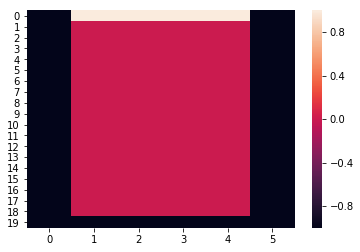

In [2]:
simpleTrack = np.zeros((20,6))
simpleTrack[0] = np.ones(6)
simpleTrack[19,1:-1] = -1
simpleTrack[:,0] = -1
simpleTrack[:,-1] = -1
sns.heatmap(simpleTrack)

#### Single turn track

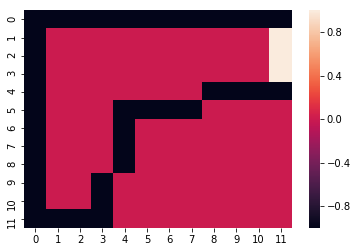

In [4]:
turn = np.zeros((12, 12))
rr, cc = draw.polygon_perimeter([11,11,5,4,0,0,0],
                                [0,3,4,11,11,5,0],
                            shape=turn.shape, clip=True)
turn[rr, cc] = -1
lastCol = turn[:,11]
lastCol[lastCol == -1] = 1
lastRow = turn[11:]
lastRow[lastRow == -1] = -1
turn[-1,0], turn[-1, 3] = -1,-1
turn[0,11], turn[4, 11] = -1,-1
turnTrack = turn
sns.heatmap(turnTrack)

### Building the environment

In [12]:
def nextMove(state, action, track):
    """
    Actions: UP(0), RIGHT(1), DOWN(2), LEFT(3)
    State: (row, col)
    """
    if action == 0:
        nextState = (state[0] - 1, state[1])
    elif action == 1:
        nextState = (state[0], state[1] + 1)
    elif action == 2:
        nextState = (state[0] + 1, state[1])
    else:
        nextState = (state[0], state[1] - 1)
        
    reward = track[nextState[0],nextState[1]]
    return nextState, reward


def epsilon_greedy(e, state, policy):
    """
    Epsilon: greedy for action selectiona exploration
    """
    be_greedy = np.random.random() < e
    if be_greedy:
        action = policy[state]
    else:
        action = np.random.randint(0,4)
    return action

### Algorithms

#### Monte Carlo Control with Exploratory Starts

In [23]:
def MC_ES_ep(policy, Q, start_state, track, count):
    
    state = start_state
    saR = []
    
    while True:
        action = np.random.choice([0,1,2,3])

        if state in count:
            count[state][action] += 1
        else:
            count[state] = [1 if i == action else 0 for i in range(4)]
                   
        newState, r = nextMove(state, action, track)
        saR.append([state, action, r])
        
        if r != 0:
            break
        state = newState
        
    saR.reverse()
    G = 0
    for t in saR:
        action = t[1]
        state = t[0]
        G = t[2] + G
        if state in count:
            a = (1.0/ count[state][action])
            Q[state][action] += a*(G - Q[state][action])
            policy[state[0], state[1]] = np.argmax(Q[state])
            
    return policy


def implement_MC_ES(track, eps, rmax, cmax):
    
    r,c = np.random.choice(np.arange(1, rmax)), np.random.choice(np.arange(1, cmax))
    start_state = r,c
    count = {}
    policy = np.zeros([track.shape[0], track.shape[1]])
    Q = defaultdict(lambda: np.zeros(4))

    for j in range(eps):     
        policy = MC_ES_ep(policy, Q, start_state, track, count)
        
    return policy

#### TD Lambda

In [42]:
def TD_lmbda_ep(policy, track, start_state, values, lmbda, alpha, gamma):
    
    e_weights = np.zeros([len(track[:]), len(track[0])])
    state = start_state
    action = 0
   
    for t in range(10000):
        state_new, r = nextMove(state, action, track)
        
        td_error = r + gamma*values[state_new[0], state_new[1]] - values[state[0], state[1]]
        e_weights[state[0], state[1]] = 1
    
        #update values and eligibility weights
        values = values + alpha*td_error*e_weights
        e_weights = gamma*lmbda*e_weights
        state = state_new
        action = epsilon_greedy(0.1, state, policy)
        
        if r != 0:
            break
            
    return values

def implement_TD_lmbda(policy, track, eps, alpha, lmbda, gamma):
    values = np.zeros((len(track[:]), len(track[0])))

    if track.shape[0] == 20:
        for j in range(eps):
            start_state = (19, np.random.choice([1,2,3,4]))
            values = TD_lmbda_ep(policy, track, start_state, 
                                  values, lmbda, alpha, gamma)
    elif track.shape[1] == 12:
        for j in range(eps):
            start_state = (11, np.random.choice([1,2]))
            values = TD_lmbda_ep(policy, track, start_state, 
                                  values, lmbda, alpha, gamma)
    
    return values

### Implementing Learning Algorithms

#### SimpleTrack

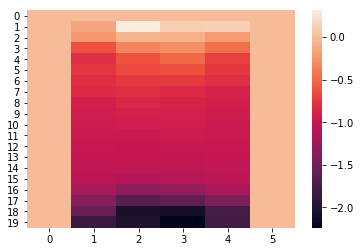

In [43]:
trackS = simpleTrack
eps = 100000
alpha = 0.1
lmbda = 0.1
gamma = 1.0

policyS = implement_MC_ES(trackS, eps, 20, 6)
valuesS = implement_TD_lmbda(policyS,trackS, eps, alpha, lmbda, gamma)
sns.heatmap(valuesS)

In [79]:
trackT = turnTrack
eps = 100000
alpha = 0.1
lmbdas = [0, 0.1, 0.5, 0.8, 1.0] 
gamma = 1.0
values = []

policyT = implement_MC_ES(trackT, eps, 5, 8)
for i, lmbda in enumerate(lmbdas):
    valuesT = implement_TD_lmbda(policyT,trackT, eps, alpha, lmbda, gamma)
    values.append(valuesT)

Lambda = 0


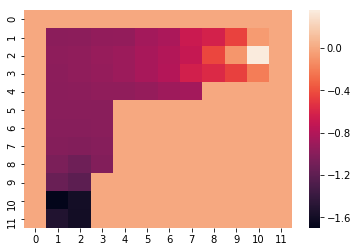

In [80]:
print("Lambda = 0")
sns.heatmap(values[0])

Lambda = 0.1


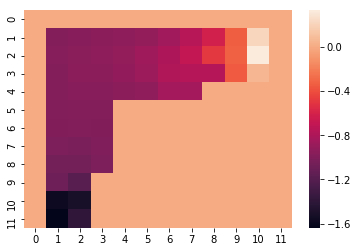

In [81]:
print("Lambda = 0.1")
sns.heatmap(values[1])

Lambda = 0.5


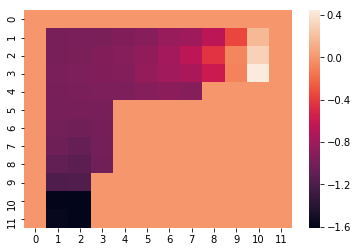

In [82]:
print("Lambda = 0.5")
sns.heatmap(values[2])

Lambda = 0.8


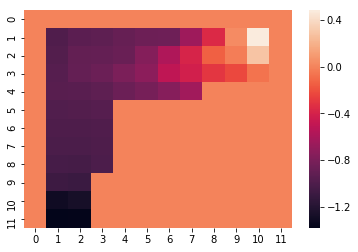

In [83]:
print("Lambda = 0.8")
sns.heatmap(values[3])

Lambda = 1.0


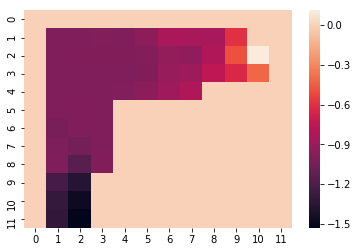

In [84]:
print("Lambda = 1.0")
sns.heatmap(values[4])